In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]="5" #,1,2,3

In [2]:
from visualize import vis_utils
from exit.utils import animate3d, t2m_bone
import numpy as np
import torch
from tqdm import tqdm
from exit.utils import visualize_2motions
from utils.motion_process import recover_from_ric
from instantmotion import InstantMotion, clip_model
from dataset import dataset_TM_eval
from utils.word_vectorizer import WordVectorizer

In [3]:
w_vectorizer = WordVectorizer('./glove', 'our_vab')
val_loader = dataset_TM_eval.DATALoader('t2m', True, 32, w_vectorizer)

  0%|          | 0/4384 [00:00<?, ?it/s]

100%|██████████| 4384/4384 [00:01<00:00, 2502.31it/s]

Pointer Pointing at 0


### MDM

In [31]:
### Text to Motion
npy_path = '/home/epinyoan/git/motion-diffusion-model/save/humanml_trans_enc_512/samples_humanml_trans_enc_512_000200000_seed10_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel/results.npy'
sample_idx = 0 
rep_idx = 0

### inbetween
# npy_path = '/home/epinyoan/git/motion-diffusion-model/save/temp/edit_humanml_trans_enc_512_000200000_in_between_seed10_A_person_throws_a_ball/results.npy'
# sample_idx = 0 # total sample (default) = 10
# rep_idx = 2 # repeat (default) = 3

### upper body
# npy_path = '/home/epinyoan/git/motion-diffusion-model/save/temp/edit_humanml_trans_enc_512_000200000_upper_body_seed10_A_person_throws_a_ball_2/results.npy'
# sample_idx = 0 # total sample (default) = 1
# rep_idx = 1 # repeat (default) = 3

motions = np.load(npy_path, allow_pickle=True)
motions = motions[None][0]
motions['motion'].shape, motions['num_samples']
absl_idx = rep_idx * motions['num_samples'] + sample_idx
length = motions['lengths'][absl_idx]
_motions = motions['motion'][absl_idx][:, :, :length].transpose(2, 0, 1)

In [35]:
# MLD
# npy_path = '/home/epinyoan/git/motion-latent-diffusion/results/mld/1222_PELearn_Diff_Latent1_MEncDec49_MdiffEnc49_bs64_clip_uncond75_01/samples_2023-11-09-10-18-04/Example_196_batch0_0.npy'
# _motions = np.load(npy_path, allow_pickle=True)
# T2M-GPT
npy_path = '/home/epinyoan/git/MaskText2Motion/T2M-GPT/output/npy/a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel4/motions.npy'
_motions = np.load(npy_path, allow_pickle=True)
_motions = _motions[0] * val_loader.dataset.std + val_loader.dataset.mean
_motions = recover_from_ric(torch.from_numpy(_motions).float(), 22).numpy()

In [ ]:
# visualize
animate3d(_motions, BONE_LINK=t2m_bone, first_total_standard=63, axis_visible=True)

In [6]:
# save obj
# npy2obj = vis_utils.npy2obj(_motions, 'mdm_inbtween_seed10_a_person_walks_backwards,_turns_around_and_walks_backwards_the_other_way___A_person_throws_a_ball')
# npy2obj = vis_utils.npy2obj(_motions, 'mdm_upper_a_man_rises_from_the_ground_walks_in_a_circle_and_sits_back_down_on_the_ground___A_person_throws_a_ball', skip=1)
npy2obj = vis_utils.npy2obj(_motions, 'mdm_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel', skip=1)
# npy2obj = vis_utils.npy2obj(_motions, 'mld_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel', skip=1)
# npy2obj = vis_utils.npy2obj(_motions, 't2mgpt_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel', skip=1)

./body_models/
Running SMPLify, it may take a few minutes.


/home/epinyoan/git/MaskText2Motion/T2M-BD/visualize/simplify_loc2rot.py:110: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Saving obj files to [/home/epinyoan/git/MaskText2Motion/T2M-BD/output/obj/2023-11-10-21-01-20_mdm_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel]


100%|██████████| 196/196 [00:07<00:00, 26.12it/s]


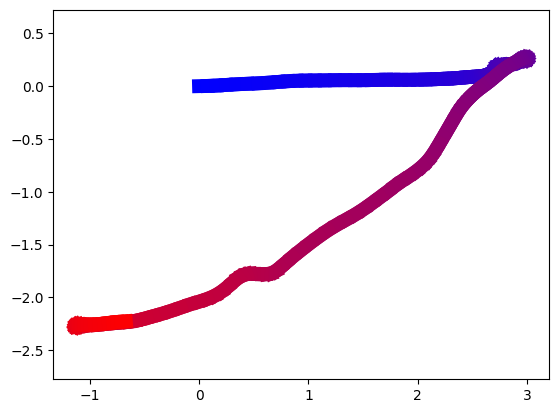

In [37]:
### T2M-GPT trajectory
def draw_trajectory(_motions, y_direct=-1):
    if _motions.shape[-1] != 3:
        _motions = _motions * val_loader.dataset.std + val_loader.dataset.mean
        _motions = recover_from_ric(torch.from_numpy(_motions).float(), 22).numpy()
    plt_x = _motions[:, 0, [2]]
    plt_y = y_direct * _motions[:, 0, [0]]
    for i in range(_motions.shape[0]-1):
        c = i/_motions.shape[0]
        plt.plot(plt_x[i:i+2], plt_y[i:i+2], color = (c, 0, (1-c)), linewidth=10)

    ymin = plt_y.min() - .5
    ymax = ymin + 3.5
    ax = plt.gca()
    ax.set_ylim([ymin, ymax])
draw_trajectory(_motions, y_direct=-1)


### InstantMotion

In [7]:
instant_motion = InstantMotion().cuda()

mock:: opt


In [40]:
# word_embeddings, pos_one_hots, text, sent_len, pose, m_length, token, name = next(iter(val_loader))
# pred_pose = instant_motion(text, m_length.cuda())
m_length = torch.tensor([196])
text = ['a man rises from the ground, walks in a circle and sits back down on the ground.']
pred_pose = instant_motion(text, m_length.cuda())

In [ ]:
k = 0
x = pred_pose[k].detach().cpu().numpy()
l = m_length[k]
caption = text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

##### In-between

In [84]:
text = ['a person walks backwards, turns around and walks backwards the other way.']
m_length = torch.tensor([196])
base_pose = instant_motion(text, m_length.cuda())

In [ ]:
k = 0
x = base_pose[k].detach().cpu().numpy()
l = m_length[k]
caption = text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

In [86]:
# instant_motion.inbetween(base_pose, )
start_f = (m_length*.25).int()
end_f = (m_length*.75).int()
inbetween_text = ['A person throws a ball'] * len(text)
pred_pose_inbetween = instant_motion.inbetween(base_pose, m_length, start_f, end_f, inbetween_text)

In [ ]:
k = 0
x = pred_pose_inbetween[k, :m_length[k]].detach().cpu().numpy()
l = m_length[k]
caption = inbetween_text[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

In [ ]:
_motions = pred_pose_inbetween[k, :m_length[k]].detach().cpu().numpy() * val_loader.dataset.std + val_loader.dataset.mean
_motions = recover_from_ric(torch.from_numpy(_motions).float(), 22).numpy()
animate3d(_motions, BONE_LINK=t2m_bone, first_total_standard=63)

In [35]:
npy2obj = vis_utils.npy2obj(pred_pose_inbetween[k, :m_length[k]].detach().cpu().numpy(), 
                            'instantMotion_inbtween_seed10_a_person_walks_backwards,_turns_around_and_walks_backwards_the_other_way___A_person_throws_a_ball_2',
                            val_loader.dataset.std, 
                            val_loader.dataset.mean)

./body_models/
Running SMPLify, it may take a few minutes.


Saving obj files to [/home/epinyoan/git/MaskText2Motion/T2M-BD/output/obj/2023-11-04-16-06-30_instantMotion_inbtween_seed10_a_person_walks_backwards,_turns_around_and_walks_backwards_the_other_way___A_person_throws_a_ball_2]


100%|██████████| 196/196 [00:08<00:00, 23.65it/s]


##### Long Range

In [7]:
__break__ = False
for word_embeddings1, pos_one_hots1, clip_text1, sent_len1, pose1, m_length1, token1, name1 in val_loader:
    for i, text1 in enumerate(clip_text1):
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in text1:
        if 'jump' in text1:
        # if 'a man rises from the ground, walks in a circle and sits back down on the ground.' in text1:
        # if 'a person walks backwards, turns around and walks backwards the other way.' in text1:
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in text1:
            __break__ = True
            print(text1)
            break
    if __break__:
        break

doing a cartwheel then jumping up and down.


In [60]:
caption, l, k

('the toon is crouched down on one knee, stands up shuffles, raising both hands in front of them while walking to the end of the plane & turning around.',
 tensor(196),
 1)

In [65]:
caption, l, k

('a person balances on their left foot while kicking in multiple directions with their right foot.',
 tensor(196),
 5)

In [67]:
caption, l, k

('a person reaches forwards with their right hand then does a rowing motion with both hands.',
 tensor(196),
 6)

In [72]:
caption, l, k

('a person laying face down on the ground and then slowly crawling backwards',
 tensor(196),
 9)

In [75]:
caption, l, k

('a person walks forward then turns completely around and does a cartwheel.',
 tensor(196),
 11)

In [ ]:
k = 11
x = pose1[k].detach().cpu().numpy()
l = m_length1[k]
caption = clip_text1[k]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l)

In [6]:
text = ['the toon is crouched down on one knee, stands up shuffles, raising both hands in front of them while walking to the end of the plane & turning around.',
        'a person balances on their left foot while kicking in multiple directions with their right foot.',
        'a person reaches forwards with their right hand then does a rowing motion with both hands.',
        'a person laying face down on the ground and then slowly crawling backwards',
        'a person walks forward then turns completely around and does a cartwheel.'
]
m_length = torch.tensor([196, 196, 196, 196, 196])
pred_pose = instant_motion.long_range(text, m_length.cuda())

render time: 0.213795 seconds


In [ ]:
_motions = pred_pose[0].detach().cpu().numpy() * val_loader.dataset.std + val_loader.dataset.mean
_motions = recover_from_ric(torch.from_numpy(_motions).float(), 22).numpy()
animate3d(_motions, BONE_LINK=t2m_bone, first_total_standard=63)

In [102]:
npy2obj = vis_utils.npy2obj(_motions[::2], 'InstantMotion-longrange')

./body_models/
Running SMPLify, it may take a few minutes.
Saving obj files to [/home/epinyoan/git/MaskText2Motion/T2M-BD/output/obj/2023-11-04-21-18-49_InstantMotion-longrange]


100%|██████████| 506/506 [00:19<00:00, 26.19it/s]


##### InstantMotion Upper Body Editing

In [4]:
instant_motion_upper = InstantMotion(is_upper_edit=True, 
                                     extra_args = {'mean':val_loader.dataset.mean, 
                                      'std':val_loader.dataset.std}).cuda()

mock:: opt


In [24]:
word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name = next(iter(val_loader))

In [5]:
__break__ = False
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name in val_loader:
    for i, text in enumerate(clip_text):
        if 'a man rises from the ground, walks in a circle and sits back down on the ground.' in text:
            __break__ = True
            print(i, text)
            break
    if __break__:
        break

6 a man rises from the ground, walks in a circle and sits back down on the ground.


In [6]:
token_len = int(pose.shape[1]/4)
lower_mask = torch.zeros((pose.shape[0], token_len), dtype=int)
lower_mask[:, (torch.arange(int(token_len/2))*2) + 1] = 1
lower_mask[:, torch.arange(10) ] = 1
lower_mask[:] = 1

In [49]:
# m_length[4] = 100

In [20]:
pred_pose_upper = instant_motion_upper.upper_edit(pose, m_length, ['MOVE THIS OUT']*len(clip_text), lower_mask=lower_mask)

In [21]:
_motions = pred_pose_upper[i].detach().cpu().numpy() * val_loader.dataset.std + val_loader.dataset.mean
_motions = recover_from_ric(torch.from_numpy(_motions).float(), 22).numpy()
animate3d(_motions, BONE_LINK=t2m_bone, first_total_standard=27, axis_visible=True) # first_total_standard=63

In [22]:
npy2obj = vis_utils.npy2obj(_motions, 'InstantMotion-upperedit_handsUpInTheAir', skip=2)

./body_models/
Running SMPLify, it may take a few minutes.


/home/epinyoan/git/MaskText2Motion/T2M-BD/visualize/simplify_loc2rot.py:110: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Saving obj files to [/home/epinyoan/git/MaskText2Motion/T2M-BD/output/obj/2023-11-11-21-41-08_InstantMotion-upperedit_handsUpInTheAir]


100%|██████████| 98/98 [00:03<00:00, 26.98it/s]


##### Visualize Samples

In [8]:
instant_motion = InstantMotion().cuda()

mock:: opt


In [8]:
__break__ = False
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name in val_loader:
    for i, text in enumerate(clip_text):
        # if True: #'cartwheel' in text:
        if 'a person walks forward then turns completely around and does a cartwheel.' in text:
            __break__ = True
            print(i, m_length[i], text)
            break
    if __break__:
        break

14 tensor(196) a person walks forward then turns completely around and does a cartwheel.


In [41]:
# a person walks forward then turns completely around and does a cartwheel.
pred_pose = instant_motion(clip_text, m_length.cuda())
x = pose[i].detach().cpu().numpy()
y = pred_pose[i].detach().cpu().numpy()
l = m_length[i]
caption = clip_text[i]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, 't2m', l, y, save_path=None)

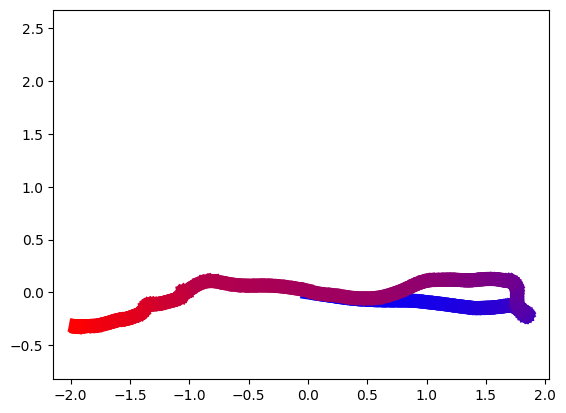

In [38]:
draw_trajectory(x, y_direct=1)

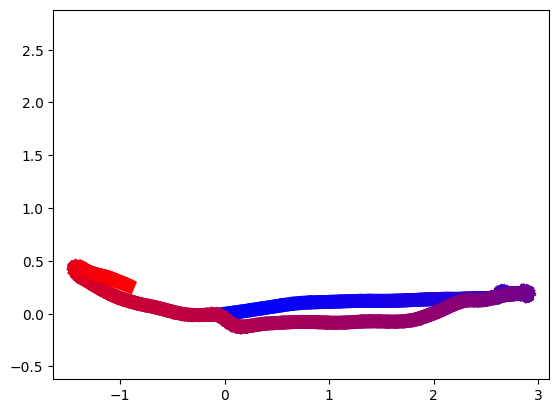

In [42]:
draw_trajectory(y, y_direct=1)

In [46]:
npy2obj = vis_utils.npy2obj(y, 
                            'instantmotion_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel', 
                            std=val_loader.dataset.std,
                            mean=val_loader.dataset.mean,
                            skip=1)

./body_models/
Running SMPLify, it may take a few minutes.
Saving obj files to [/home/epinyoan/git/MaskText2Motion/T2M-BD/output/obj/2023-11-10-11-00-22_instantmotion_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel]


100%|██████████| 196/196 [00:07<00:00, 26.32it/s]


In [25]:
npy2obj = vis_utils.npy2obj(x, 
                            'gt_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel', 
                            std=val_loader.dataset.std,
                            mean=val_loader.dataset.mean,
                            skip=1)

./body_models/
Running SMPLify, it may take a few minutes.
Saving obj files to [/home/epinyoan/git/MaskText2Motion/T2M-BD/output/obj/2023-11-10-10-38-03_gt_a_person_walks_forward_then_turns_completely_around_and_does_a_cartwheel]


100%|██████████| 196/196 [00:07<00:00, 26.00it/s]


### Verify InstantMotion by Eval

In [21]:

from options.get_eval_option import get_opt
from models.evaluator_wrapper import EvaluatorModelWrapper
import utils.eval_trans as eval_trans

dataset_opt_path = 'checkpoints/t2m/Comp_v6_KLD005/opt.txt'
wrapper_opt = get_opt(dataset_opt_path, torch.device('cuda'))
eval_wrapper = EvaluatorModelWrapper(wrapper_opt)
class LoggerWriterMock:
    def __init__(self):
        self.info
    def info(self, *args):
        print(*args)
    def add_scalar(self, *args):
        print(*args)
    def add_video(self, *args):
        print(*args)
logger = LoggerWriterMock()
logger.info('test')
writer = LoggerWriterMock()
writer.add_scalar('./Test/FID', 'fid', 'nb_iter')

100%|██████████| 4384/4384 [00:01<00:00, 2314.42it/s]

Pointer Pointing at 0


In [28]:
pred_pose_eval, pose, m_length, clip_text, best_fid, best_iter, best_div, best_top1, best_top2, best_top3, best_matching, best_multi, writer, logger = \
    eval_trans.evaluation_transformer('', 
        val_loader, 
        instant_motion.vqvae, 
        instant_motion.maskdecoder, 
        logger, 
        writer, 
        0, 
        best_fid=1000, 
        best_iter=0, 
        best_div=100, 
        best_top1=0, 
        best_top2=0, 
        best_top3=0, 
        best_matching=100, 
        clip_model=clip_model, 
        eval_wrapper=eval_wrapper,
        dataname='t2m',
        num_repeat=1,
        rand_pos=True,
        CFG=-1)

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [02:15<00:00,  1.07it/s]


--> 	 Eva. Iter 0 :, 
                FID. 0.0894 , 
                Diversity Real. 9.6410, 
                Diversity. 9.5029, 
                R_precision_real. [0.51142241 0.70517241 0.8012931 ], 
                R_precision. [0.51530172 0.70560345 0.8012931 ], 
                matching_score_real. 2.956175784406991, 
                matching_score_pred. 2.919894030998493, 
                multimodality. 0.0000
./Test/FID 0.08943221410396518 0
./Test/Diversity 9.502921 0
./Test/top1 0.5153017241379311 0
./Test/top2 0.7056034482758621 0
./Test/top3 0.8012931034482759 0
./Test/matching_score 2.919894030998493 0
./Test/multimodality 0 0
--> --> 	 FID Improved from 1000.00000 to 0.08943 !!!
--> --> 	 matching_score Improved from 100.00000 to 2.91989 !!!
--> --> 	 Diversity Improved from 100.00000 to 9.50292 !!!
--> --> 	 Top1 Improved from 0.0000 to 0.5153 !!!
--> --> 	 Top2 Improved from 0.0000 to 0.7056 !!!
--> --> 	 Top3 Improved from 0.0000 to 0.8013 !!!


### Find the bad samples

In [8]:
import numpy as np
IM_score = np.load('/home/epinyoan/git/MaskText2Motion/T2M-BD/output/obj/eval_score/instantMotion.npy', allow_pickle=True)

In [47]:
len(IM_score.item().keys())
IM_array = []
for text in IM_score.item().keys():
    if 'a person walks forward then turns completely around and does a cartwheel.' in text:
        print('--', IM_score.item()[text]['r1'])
    IM_array.append((text, IM_score.item()[text]['r1']))
def my_sort(e):
    return e[1]
IM_array.sort(key=my_sort)
IM_array[1000]

-- 1.7040297


('a person lays on the ground.', 1.6456628)